# 1. Data Loading

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from torchvision import transforms as T
from torch.utils.data import Subset,DataLoader,Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import time

# get the start time
st = time.time()

/Users/yiukitcheung/Library/Mobile Documents/com~apple~CloudDocs/Desktop/UofSydney/Comp 4328 Advanced Machine Learning/Assignment_02/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# # If using mac m sries chip
# use_cuda = True if torch.backends.mps.is_available() else False
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print('We are using GPU.' if use_cuda else 'We are using CPU.')

# If using local gpu/kaggle/colab
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')


# Unzip Dataset
!unzip './datasets.zip'

We are using GPU.


### 1.1 DataLoader Definition

In [3]:
# Data Loading Class
class ImageDataset(Dataset):

    def __init__(self, path, label, transform=None,train=True):

        self.data = np.load(path)['Xtr'] if train == True else np.load(path)['Xts']
        self.label = label
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data) # Get the data size

    def __getitem__(self,idx):

        if self.transform: # Transform images if given
            image = self.transform(self.data[idx])

        label = self.label[idx]

        return image,label

### 1.2 Data Reading

In [4]:
# Data path
fash_05_path = './FashionMNIST0.5.npz'
fash_06_path = './FashionMNIST0.6.npz'
cifar_path = './CIFAR.npz'

def read_data_path(path,color=False):
    # Store the nosiy label
    train_label = np.load(path)['Str']

    # Store the clean label
    test_label = np.load(path)['Yts']

    # Set Transform
    transform = T.Compose([T.ToTensor(), T.Normalize(mean=0, std=255)])

    transform_3d = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225])])

    # Load the training set
    X_train = ImageDataset(path=path,label=train_label,transform=transform_3d) if color else ImageDataset(path=path,label=train_label,transform=transform)
    # Load the testing set
    X_test = ImageDataset(path=path,label=test_label,transform=transform_3d,train=False) if color else ImageDataset(path=path,label=test_label,transform=transform,train=False)

    return X_train,X_test,test_label

fash_05_data, fash_05_X_test, fash_05_test_label = read_data_path(fash_05_path)
fash_06_data, fash_06_X_test, fash_06_test_label = read_data_path(fash_06_path)
cifar_data,   cifar_X_test,   cifar_test_label   = read_data_path(cifar_path,color=True)


### 1.3 Load the data

In [5]:
def create_train_loader(data):

    # Set train valid set size
    train_size = np.floor(0.8 * data.__len__())
    valid_size = 1 - train_size
    batch_size = 128

    # Sample indices to for train-valid subset
    indices = np.arange(data.__len__())
    train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42)

    # Subset the Train data using sampled indices
    X_tr = Subset(data, train_indices)

    # Load the train and valid. data with bathc size
    train_loader = DataLoader(dataset=X_tr, shuffle=True, batch_size=batch_size, drop_last=True)

    return train_loader

fash_05_train_loader = create_train_loader(fash_05_data)
fash_06_train_loader = create_train_loader(fash_06_data)
cifar_train_loader   = create_train_loader(cifar_data)


### 1.4 Data Examination

In [6]:
fash_05_batch_imgs, fash_05_batch_label = next(iter(fash_05_train_loader))
fash_06_batch_imgs, fash_06_batch_label = next(iter(fash_06_train_loader))
cifar_batch_imgs  , cifar_batch_label   = next(iter( cifar_train_loader ))

def convert_big_images(images):
    return np.transpose(images, (1, 2, 0))

def plot_images(images, label_true, pred=None):
    assert len(images) == len(label_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        if images.shape[3] == 28:
            ax.imshow(images[i].reshape((28,28)))
        else:
            ax.imshow(convert_big_images(images[i]),cmap=plt.cm.gray)

        # Show true and predicted classes.
        if pred is None:
            xlabel = "True: {0}".format(label_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(label_true[i], pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    plt.savefig('Examine data.png')

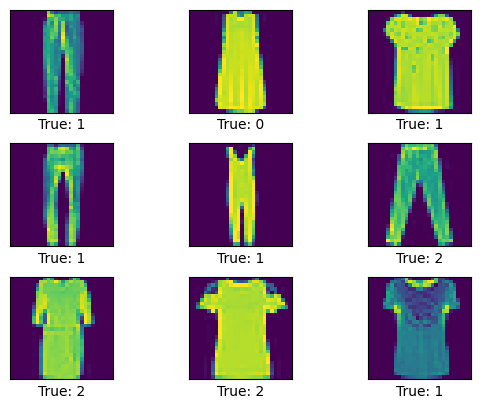

<Figure size 640x480 with 0 Axes>

In [7]:
# Plot a few fashion 0.5 images
images = fash_05_batch_imgs[:9]
label_true = fash_05_batch_label[:9]

plot_images(images=images, label_true=label_true)

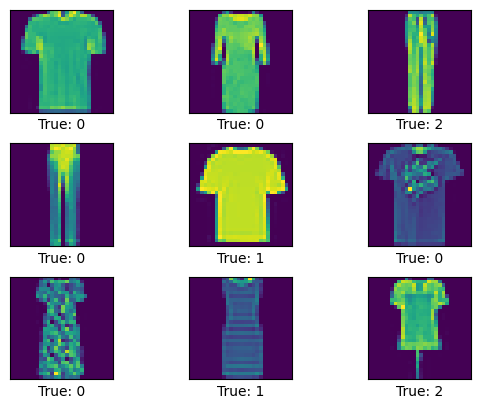

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot a few fashion 0.6 images
images = fash_06_batch_imgs[:9]
label_true = fash_06_batch_label[:9]

plot_images(images=images, label_true=label_true)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


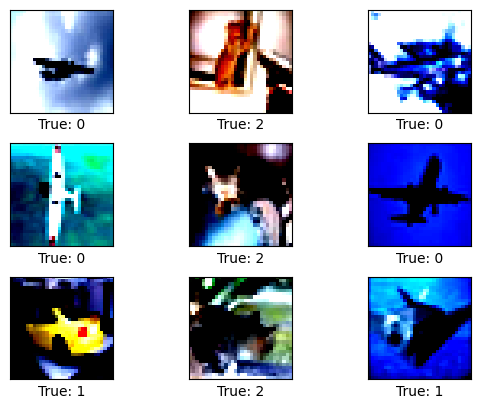

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot a few cifar images
images = cifar_batch_imgs[:9]
label_true = cifar_batch_label[:9]

plot_images(images=images, label_true=label_true)

# 2. Model Definition

#### Define ResNet 15

In [10]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=32, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=64, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=32, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=16, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

# 3. Establish Training Process

### 3.1 Define Train

In [11]:
def train(train_loader,train_losses,train_acc,model,criterion,T,optimizier,epoch,verbose):

    # Set to train mode
    model.train()
    running_loss = 0.0
    correct = 0.0
    total_labels = 0

    for (image,label) in (train_loader):
        # Convert image and label to cuda
        image, label = image.to(device), label.to(device)
        # Step.1 Reset gradient
        optimizier.zero_grad()

        # Step.2 Forward Computation
        outputs = model(image)

        # Step.3 Compute loss
        loss = criterion(outputs,label) if T is None else criterion(outputs,label,T)

        # Compute accuracy
        pred = torch.argmax(outputs,dim=1) # Prediction

        # Step.4 Backpropogation
        loss.backward()

        # Step.5 Optimize weights and bias
        optimizier.step()

        # Epoch loss record
        running_loss += loss.item()

        # Compute Acc Metric
        correct += torch.sum(pred == label).item()
        total_labels += label.size(0)

    # Train loss record
    train_loss = round(running_loss / len(train_loader),5)
    train_losses.append(train_loss)

    # Train Accuracy record
    train_accuracy = round(100 * (correct / total_labels),5)
    train_acc.append(train_accuracy)

    if verbose == 1:
        # Print each epoch result
        print("Train on {} epoch | Training Loss : {} | Train Acc : {} ".format(epoch+1,train_loss,train_accuracy))

    return train_losses,train_acc

### 3.2 Define Evaluation

In [12]:
def validation(valid_loader,valid_losses,valid_acc,model,criterion,T,epoch,verbose):

    model.eval()
    running_loss = 0.0
    correct = 0.0
    total_labels = 0

    with torch.no_grad():
        for image,label in (valid_loader):
            image, label = image.to(device), label.to(device)

            outputs = model(image)
            loss = criterion(outputs,label) if T is None else criterion(outputs,label,T)

            # Compute accuracy
            pred = torch.argmax(outputs,dim=1) # Prediction

            running_loss += loss.item()

            correct += torch.sum(pred == label).item()
            total_labels += label.size(0)

        valid_loss = round(running_loss / len(valid_loader),5)
        valid_losses.append(valid_loss)

        valid_accuracy = round(100 * (correct / total_labels),5)
        valid_acc.append(valid_accuracy)

    if verbose == 1:
        # Print each epoch result
        print("Train on {} epoch | Validation Loss : {} | Validation Acc : {}".format(epoch+1,valid_loss,valid_accuracy))
        print()
        print("=====================================================================")

    return valid_loss, valid_losses, valid_acc

### 3.3 Define Prediction

In [13]:
def prediction(model,test_loader):

    with torch.no_grad():

        batch_precision=0
        batch_recall=0
        batch_acc=0
        for (test_image,test_label) in (test_loader):
            # Convert image and label to cuda
            test_image, test_label = test_image.to(device), test_label.to(device)

            # Get predictions from model
            predictions = model(test_image)

            # Get the most likely class from the predictions
            predicted_labels = torch.argmax(predictions, dim=1)
            test_label = test_label.detach().cpu().numpy()
            predicted_labels = predicted_labels.detach().cpu().numpy()

            # Batch f1
            batch_precision +=  precision_score(test_label, predicted_labels,average='macro', zero_division=0)
            batch_recall +=  recall_score(test_label, predicted_labels,average='macro', zero_division=0)
            batch_acc += np.sum(test_label == predicted_labels).item()/len(test_label)

        # F1 Score Calculation Details
        acc = batch_acc/len(test_loader)
        precision = batch_precision/len(test_loader)
        recall = batch_recall/len(test_loader)
        f1 = 2 * (precision * recall/(precision + recall))

    return [acc,precision,recall,f1]


### 3.4 Define Model Training

In [14]:
def model_training(train_loader,valid_loader,model,criterion,T,optimizier,best_val_loss=float('inf'),num_epoch=20,verbose=1,threshold=5):
    stop=0
    tol=0
    epoch=0
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []

    while (epoch < num_epoch) & (stop == False):

        # ------------------------ #
        #   Section 1. Training    #
        #_________________________ #

        train_losses,train_acc = train(train_loader,
                                        train_losses,
                                        train_acc,model,
                                        criterion,
                                        T,
                                        optimizier,
                                        epoch=epoch,
                                        verbose=verbose)


        # ------------------------ #
        #  Section 2. Validation   #
        #_________________________ #

        valid_loss, valid_losses, valid_acc = validation(valid_loader,
                                                         valid_losses,
                                                         valid_acc,model,
                                                         criterion,
                                                         T,
                                                         epoch=epoch,
                                                         verbose=verbose)

        # ------------------------------- #
        #     Section 3. Early Stop       #
        # ------------------------------- #

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            if verbose == 1:
                print(f"Best val loss so far: {best_val_loss:.4f}")
            tol = 0
        else:
            tol += 1
            if tol == threshold:
                if verbose == 1:
                    print(f"Early stopping, best val acc: {best_val_loss:.4f}")
                stop=True
        epoch+=1

    return valid_acc,train_acc,best_val_loss

### 3.5 Define DMI Loss Function

In [15]:
class DMILoss(nn.Module):
    def __init__(self):
        super(DMILoss, self).__init__()

    def forward(self, logits, targets,T):
        # Calculate the confusion matrix
        one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.size(1))
        C = (logits.t().matmul(one_hot.float()) + 1e-8 ).to('cpu')  # Confusion matrix with a small value to prevent singularity
        # Compute the determinant of C
        det_C = torch.det(C)
        # Maximize the determinant (or minimize its negative)
        loss = -torch.log(torch.abs(det_C) + 1e-8)
        loss = loss.to(device)

        return torch.mean(loss)

### 3.6 Define Reweight Technique

In [16]:
class ReWeight(nn.Module):
    def __init__(self):
        super(ReWeight, self).__init__()

    def forward(self, logits, targets,T):

        # Dervie the posterior prob. from logits
        out_softmax = F.softmax(logits,dim=1)
        # Transpose the out_softmax for further computation
        out_softmax = torch.transpose(out_softmax,0,1)
        # Compute Clean label Estimation using transition matrix
        clean_x = torch.matmul(T,out_softmax) # forward nosie learning
        # Estimate Re-weighted Beta
        beta = torch.div(out_softmax,clean_x)
        # Compute the loss
        loss = F.cross_entropy(logits, targets)
        # Combine the beta weight and loss and form a new loss
        loss = beta * loss

        return torch.mean(loss)

# 4 With Flip Rate

In [17]:
# Define trans matrix
Transition_matrices_dict = {
    'fashionmnist05': torch.Tensor([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]]).to(device),
    'fashionmnist06': torch.Tensor([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]]).to(device)}

In [18]:
# Define K-Fold
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

# Define a cv training function
def cv_training(data,test,trans_matrix,data_name,channels=1,batch_size=128,cv=cv,DMI=False):

    # Set technique type
    DMI = DMI

    # Initiate list and dict
    fold_val_loss_list = []
    fold_pred_dict = {}

    # Create 10-fold data for cv-training
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):

        # ------------------------- #
        #    Step 1. Data Loading   #
        # ------------------------- #

        # Prepare testing data for prediction evaluation
        test_loader = DataLoader(test, shuffle=False, batch_size=batch_size, drop_last=False)

        # Create subset of training set and validation set
        dataset_train = Subset(data, train_idx)
        dataset_valid = Subset(data, val_idx)
        train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
        valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False,drop_last=True)

        # ----------------------------------- #
        #    Step 2. Set Model Parameter      #
        # ----------------------------------- #

        # Define model and noise robust technique
        re_weight_model = ResNet(block, [2,2,2,2], channels,3).to(device)
        DMI_model = ResNet(block, [2,2,2,2], channels,3).to(device)

        # Use model conditionally
        model = re_weight_model if (DMI is False)  else (DMI_model)

        # Loss function
        criterion = ReWeight() if (DMI is False )& (trans_matrix != None) else (DMILoss() if DMI else nn.CrossEntropyLoss())

        # Optimization
        optimizier = optimizer.SGD(model.parameters(),lr=0.001,momentum=0.9)

        print('Fold : {}'.format(fold+1))

        # ----------------------------------- #
        #    Step 3. Train and Validate       #
        # ----------------------------------- #

        valid_acc,train_acc,best_val_loss = model_training(train_loader,
                                                            valid_loader,
                                                            model,
                                                            criterion,
                                                            trans_matrix,
                                                            optimizier,
                                                            verbose=0)
        
        # Store the best loss in current fold
        fold_val_loss_list.append(best_val_loss)

        # Print the best loss for each fold
        print('Best Result in Fold : {} is {}'.format(fold+1,best_val_loss))
        print('<------------------------------------------------------------------->')
        print()
        
        # Store the training and validation curve of the 1st fold
        if fold == 1:
            plt.plot(train_acc,label="Train")
            plt.plot(valid_acc,label="Validate")
            plt.title(f'{data_name} Training & Validating Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.savefig(f'{data_name} validating accuracy.png')

        # ------------------------------- #
        #       Step 4. Prediction        #
        # ------------------------------- #
        
        # Store each fold prediction to a dictionary
        fold_pred_dict[fold+1] = prediction(model,test_loader)

    return fold_val_loss_list,fold_pred_dict

#### DMI Loss on Fashion05

Fold : 1
Best Result in Fold : 1 is -20.82368
<------------------------------------------------------------------->

Fold : 2
Best Result in Fold : 2 is -22.52961
<------------------------------------------------------------------->

Fold : 3
Best Result in Fold : 3 is -23.14285
<------------------------------------------------------------------->

Fold : 4
Best Result in Fold : 4 is -23.67966
<------------------------------------------------------------------->

Fold : 5
Best Result in Fold : 5 is -22.24426
<------------------------------------------------------------------->

Fold : 6
Best Result in Fold : 6 is -22.03087
<------------------------------------------------------------------->

Fold : 7
Best Result in Fold : 7 is -38.47872
<------------------------------------------------------------------->

Fold : 8
Best Result in Fold : 8 is -21.87538
<------------------------------------------------------------------->

Fold : 9
Best Result in Fold : 9 is -23.68698
<-----------------

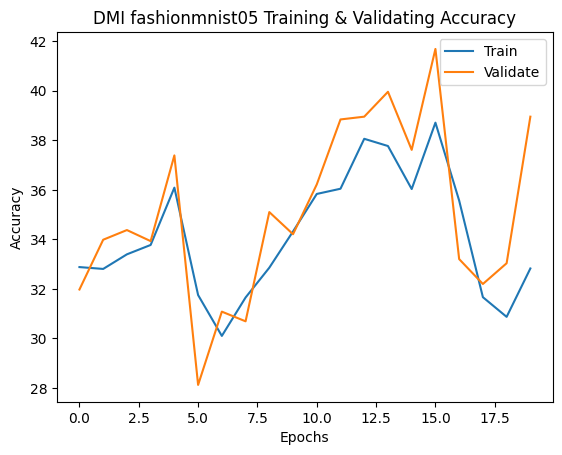

In [19]:
DMI_05, DMI_05_results = cv_training(data = fash_05_data,
                                    test = fash_05_X_test,
                                    trans_matrix = Transition_matrices_dict['fashionmnist05'],
                                    data_name = 'DMI fashionmnist05',
                                    DMI=True)

#### DMI Loss on Fashion06

Fold : 1
Best Result in Fold : 1 is -21.15813
<------------------------------------------------------------------->

Fold : 2
Best Result in Fold : 2 is -20.59279
<------------------------------------------------------------------->

Fold : 3
Best Result in Fold : 3 is -21.29169
<------------------------------------------------------------------->

Fold : 4
Best Result in Fold : 4 is -23.21109
<------------------------------------------------------------------->

Fold : 5
Best Result in Fold : 5 is -21.24715
<------------------------------------------------------------------->

Fold : 6
Best Result in Fold : 6 is -22.01538
<------------------------------------------------------------------->

Fold : 7
Best Result in Fold : 7 is -22.69355
<------------------------------------------------------------------->

Fold : 8
Best Result in Fold : 8 is -20.27292
<------------------------------------------------------------------->

Fold : 9
Best Result in Fold : 9 is -20.54047
<-----------------

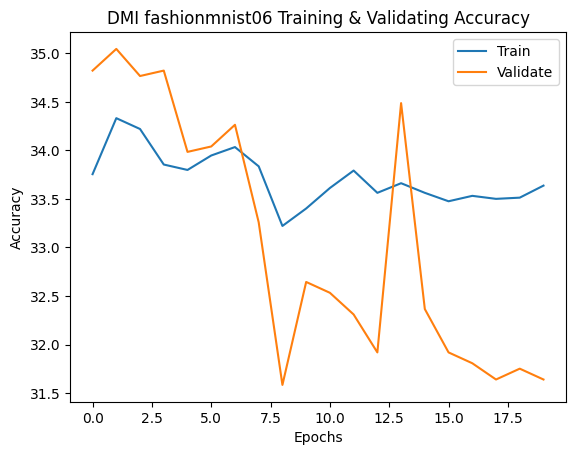

In [20]:
DMI_06, DMI_06_results = cv_training(data = fash_06_data,
                                    test = fash_06_X_test,
                                    trans_matrix = Transition_matrices_dict['fashionmnist06'],
                                    data_name = 'DMI fashionmnist06',
                                    DMI=True)

#### ReWeight Technique on Fashion05

Fold : 1
Best Result in Fold : 1 is 1.00931
<------------------------------------------------------------------->

Fold : 2
Best Result in Fold : 2 is 0.99247
<------------------------------------------------------------------->

Fold : 3
Best Result in Fold : 3 is 1.02954
<------------------------------------------------------------------->

Fold : 4
Best Result in Fold : 4 is 1.0315
<------------------------------------------------------------------->

Fold : 5
Best Result in Fold : 5 is 1.0271
<------------------------------------------------------------------->

Fold : 6
Best Result in Fold : 6 is 1.01551
<------------------------------------------------------------------->

Fold : 7
Best Result in Fold : 7 is 1.02363
<------------------------------------------------------------------->

Fold : 8
Best Result in Fold : 8 is 1.03252
<------------------------------------------------------------------->

Fold : 9
Best Result in Fold : 9 is 1.00171
<-------------------------------------

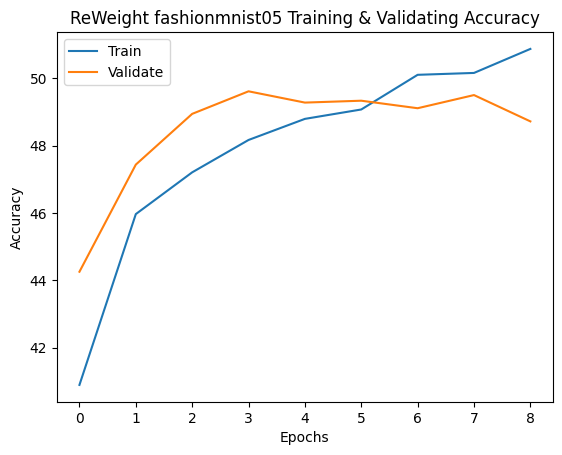

In [21]:
reweight_05, reweight_05_results = cv_training(data = fash_05_data,
                                                test = fash_05_X_test,
                                                trans_matrix = Transition_matrices_dict['fashionmnist05'],
                                                data_name = 'ReWeight fashionmnist05')

#### ReWeight Technique on Fashion06

Fold : 1
Best Result in Fold : 1 is 1.09728
<------------------------------------------------------------------->

Fold : 2
Best Result in Fold : 2 is 1.09449
<------------------------------------------------------------------->

Fold : 3
Best Result in Fold : 3 is 1.09452
<------------------------------------------------------------------->

Fold : 4
Best Result in Fold : 4 is 1.10533
<------------------------------------------------------------------->

Fold : 5
Best Result in Fold : 5 is 1.10466
<------------------------------------------------------------------->

Fold : 6
Best Result in Fold : 6 is 1.09513
<------------------------------------------------------------------->

Fold : 7
Best Result in Fold : 7 is 1.0958
<------------------------------------------------------------------->

Fold : 8
Best Result in Fold : 8 is 1.09393
<------------------------------------------------------------------->

Fold : 9
Best Result in Fold : 9 is 1.09854
<------------------------------------

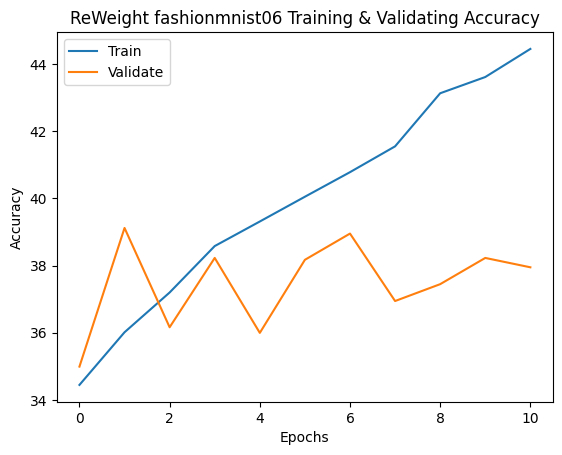

In [22]:
reweight_06, reweight_06_results = cv_training(data = fash_06_data,
                                                test = fash_06_X_test,
                                                trans_matrix = Transition_matrices_dict['fashionmnist06'],
                                                data_name = 'ReWeight fashionmnist06')

#  5 No Flip Rate

In [23]:
def trans_matrix_estimation(model,test_loader,label):
    model.eval()
    predicted_labels = []
    
    for (image_test, test_label) in (test_loader):
        image_test = image_test.to(device)
        test_label = test_label.to(device)

        with torch.no_grad():
            outputs = model(image_test)
        # Obtain the Posterior probability of noisy label
        probs = F.softmax(outputs, dim=1).cpu().detach().numpy()
        # Obtain the predicted class based on the posterior probability
        predicted_class = np.argmax(probs, 1)
        # Store the results
        predicted_labels.extend(predicted_class)

    # Compare the predicted result with the true clean labels
    confusion = confusion_matrix(label, predicted_labels)

    # Compute the flip rate for each true class being misclassified
    transition_matrix = confusion / confusion.sum(axis=1)[:, np.newaxis]

    return transition_matrix

In [24]:
# Define a transition matrix estimator
def t_estimation(data,test,label,channels=1,batch_size=128):

    test_loader = DataLoader(test, shuffle=False, batch_size=batch_size, drop_last=False)

    # Sample indices to for train-valid subset
    indices = np.arange(data.__len__())
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

    # Create subset
    dataset_train = Subset(data, train_idx)
    dataset_valid = Subset(data, val_idx)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
    valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False,drop_last=True)

    # Define model and noise robust technique
    model =  ResNet(block, [2,2,2,2], channels,3).to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizaer
    optimizier = optimizer.SGD(model.parameters(),lr=0.001,momentum=0.9)

    # Train and validate model
    _,_,_ = model_training(train_loader,
                            valid_loader,
                            model,
                            criterion,
                            None,
                            optimizier,
                            num_epoch=30,
                            verbose=0,
                            threshold=10)

    # Determine if flip rate is known or not
    transition_matrix = trans_matrix_estimation(model,test_loader,label)

    return transition_matrix

#### 5.1 Validate Transition Matrix Estimator

In [25]:
# Estimate a transition matrix for FashionMINST0.5
fash_05_T_matrix = t_estimation(data = fash_05_data,
                                    test = fash_05_X_test,
                                    label = fash_05_test_label)

# Estimate a transition matrix for FashionMINST0.6
fash_06_T_matrix = t_estimation(data = fash_06_data,
                                    test = fash_06_X_test,
                                    label = fash_06_test_label)

# Estimate the difference between the given transition matrix and the estimated one
_05_error = np.abs([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]] - fash_05_T_matrix)
_05_MAE = np.mean(_05_error)

# Estimate the difference between the given transition matrix and the estimated one
_06_error = np.abs([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]] - fash_06_T_matrix)
_06_MAE = np.mean(_06_error)

print(f' The error for Fashion05 transition matrix is {_05_MAE} and Fashion06 transition matrix is {_06_MAE}')

 The error for Fashion05 transition matrix is 0.14933333333333332 and Fashion06 transition matrix is 0.08577777777777777


#### 5.2 Transition Matrix Estimation

In [26]:
# Estimate a transition matrix for cifar data
T_matrix = t_estimation(data = cifar_data,
                            test = cifar_X_test,
                            label = fash_05_test_label,
                            channels = 3)

#### 5.3 Apply Estimated Transtion Matrix on Cifar


Fold : 1
Best Result in Fold : 1 is 1.10628
<------------------------------------------------------------------->

Fold : 2
Best Result in Fold : 2 is 1.10337
<------------------------------------------------------------------->

Fold : 3
Best Result in Fold : 3 is 1.10612
<------------------------------------------------------------------->

Fold : 4
Best Result in Fold : 4 is 1.09522
<------------------------------------------------------------------->

Fold : 5
Best Result in Fold : 5 is 1.10591
<------------------------------------------------------------------->

Fold : 6
Best Result in Fold : 6 is 1.10492
<------------------------------------------------------------------->

Fold : 7
Best Result in Fold : 7 is 1.09903
<------------------------------------------------------------------->

Fold : 8
Best Result in Fold : 8 is 1.1015
<------------------------------------------------------------------->

Fold : 9
Best Result in Fold : 9 is 1.10158
<------------------------------------

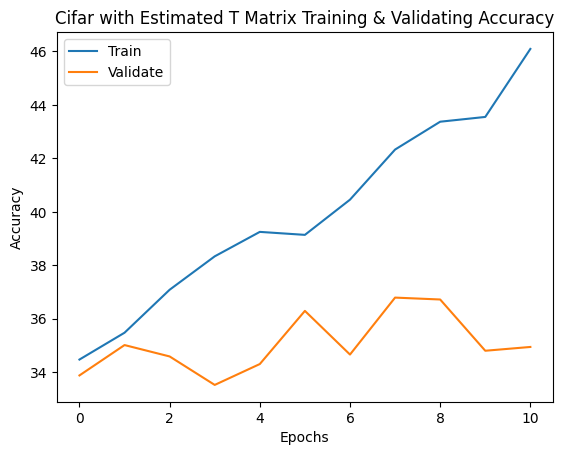

In [27]:
# Train with T
_, cifar_data_with_T_results = cv_training(data = cifar_data,
                                        test = cifar_X_test,
                                        trans_matrix = torch.Tensor(T_matrix).to(device),
                                        channels=3,
                                        data_name = 'Cifar with Estimated T Matrix')

Fold : 1
Best Result in Fold : 1 is 1.10576
<------------------------------------------------------------------->

Fold : 2
Best Result in Fold : 2 is 1.11041
<------------------------------------------------------------------->

Fold : 3
Best Result in Fold : 3 is 1.10823
<------------------------------------------------------------------->

Fold : 4
Best Result in Fold : 4 is 1.10093
<------------------------------------------------------------------->

Fold : 5
Best Result in Fold : 5 is 1.10792
<------------------------------------------------------------------->

Fold : 6
Best Result in Fold : 6 is 1.106
<------------------------------------------------------------------->

Fold : 7
Best Result in Fold : 7 is 1.10609
<------------------------------------------------------------------->

Fold : 8
Best Result in Fold : 8 is 1.09984
<------------------------------------------------------------------->

Fold : 9
Best Result in Fold : 9 is 1.09618
<-------------------------------------

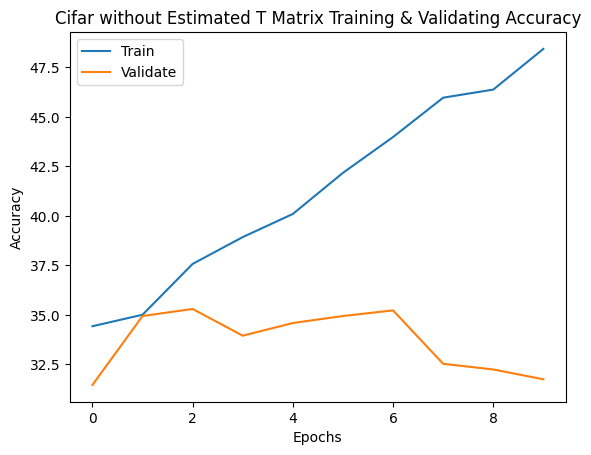

In [28]:
# Train Without T
_, cifar_data_no_T_esults = cv_training(data = cifar_data,
                                    test = cifar_X_test,
                                    trans_matrix = None,
                                    channels=3,
                                    data_name = 'Cifar without Estimated T Matrix')

# 6 Results

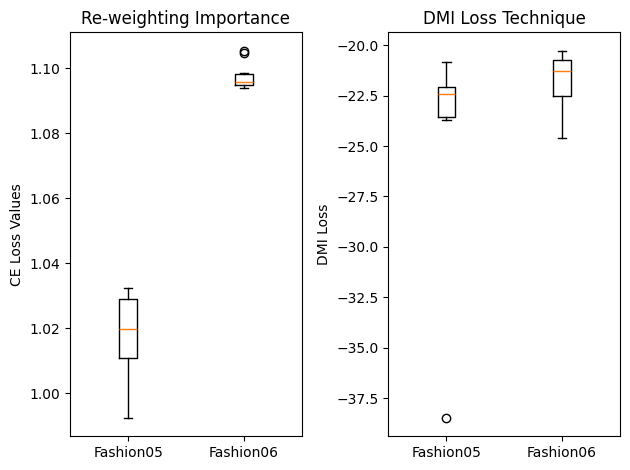

In [29]:
import matplotlib.pyplot as plt

# Create dataframe object to store result stored in dict
valid_df = pd.DataFrame([DMI_05, DMI_06,reweight_05, reweight_06]).T
valid_df.columns = ['DMI 05','DMI 06','re-weighting 05','re-weighting 06']

# Create a list of data sets
reweight_list = [reweight_05, reweight_06]
DMI_list = [DMI_05, DMI_06]

# Create subplot
plt.subplot(1, 2, 1)
plt.boxplot(reweight_list)
plt.title('Re-weighting Importance')
plt.xticks([1,2],['Fashion05', 'Fashion06'])
plt.ylabel('CE Loss Values')

# Create subplot
plt.subplot(1, 2, 2)
plt.boxplot(DMI_list)
plt.title('DMI Loss Technique')
plt.xticks([1,2],['Fashion05', 'Fashion06'])
plt.ylabel('DMI Loss')

# Get a better layout
plt.tight_layout()
plt.savefig('CV validation loss boxplot')
plt.show()


In [30]:
# Create dataframe object to store result stored in dict
dmi05_df = pd.DataFrame(DMI_06_results)
dmi06_df = pd.DataFrame(DMI_05_results)
reweight05_df = pd.DataFrame(reweight_05_results)
reweight06_df = pd.DataFrame(reweight_06_results)

# Merge all result accordingly
prediction_results = pd.concat([dmi05_df,dmi06_df,reweight05_df,reweight06_df]).transpose()
prediction_results.columns = ['DMI 05','DMI 05','DMI 05','DMI 05',
                                'DMI 06','DMI 06','DMI 06','DMI 06',
                                'Reweight 05','Reweight 05','Reweight 05','Reweight 05',
                                'Reweight 06','Reweight 06','Reweight 06','Reweight 06']

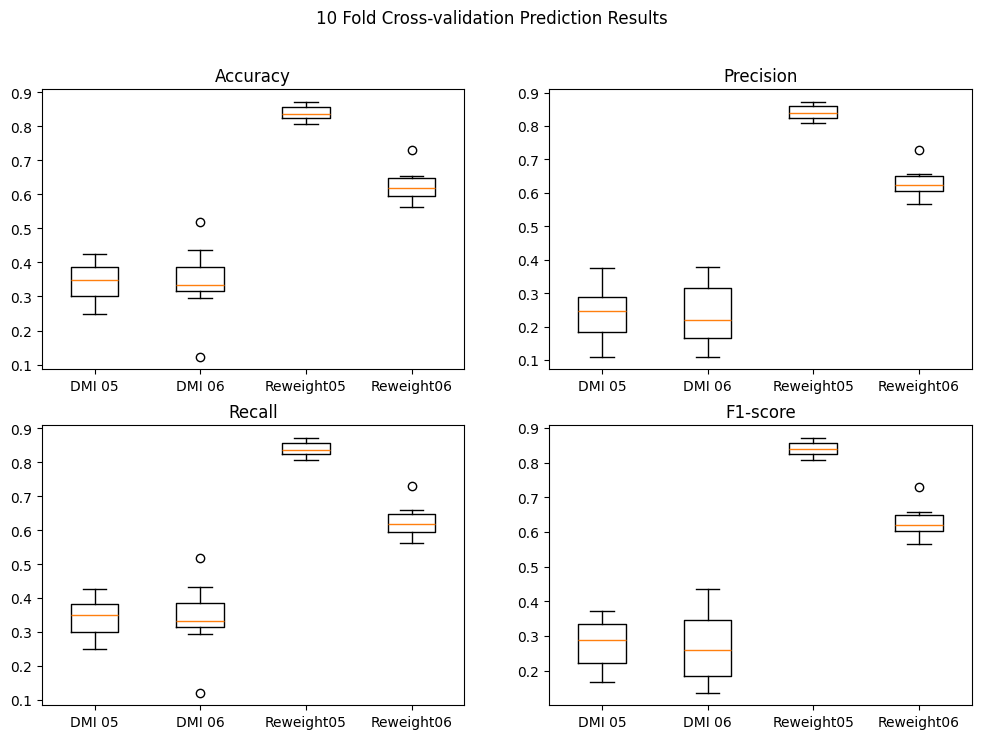

In [31]:
# Create subplots
fig, axs = plt.subplots(2, 2,figsize=(12, 8))

# Put all subplots together
axs[0, 0].boxplot(prediction_results.iloc[:,[0,4,8,12]])
axs[0, 0].set_xticks([1,2,3,4],['DMI 05','DMI 06','Reweight05','Reweight06'])
axs[0, 0].set_title('Accuracy')
axs[0, 1].boxplot(prediction_results.iloc[:,[1,5,9,13]])
axs[0, 1].set_xticks([1,2,3,4],['DMI 05','DMI 06','Reweight05','Reweight06'])
axs[0, 1].set_title('Precision')
axs[1, 0].boxplot(prediction_results.iloc[:,[2,6,10,14]])
axs[1, 0].set_xticks([1,2,3,4],['DMI 05','DMI 06','Reweight05','Reweight06'])
axs[1, 0].set_title('Recall')
axs[1, 1].boxplot(prediction_results.iloc[:,[3,7,11,15]])
axs[1, 1].set_xticks([1,2,3,4],['DMI 05','DMI 06','Reweight05','Reweight06'])
axs[1, 1].set_title('F1-score')

fig.suptitle('10 Fold Cross-validation Prediction Results', fontsize=12)
plt.savefig('10-fold prediction results.png')
plt.show()


In [32]:
# Create dataframe object to store result stored in dict
cifar_with_T_df = pd.DataFrame(cifar_data_with_T_results)
cifar_with_no_T_df = pd.DataFrame(cifar_data_no_T_esults)
cifar_results = pd.concat([cifar_with_T_df,cifar_with_no_T_df]).transpose()
cifar_results.columns = ['With est. T','With est. T','With est. T','With est. T',
                        'Without est. T','Without est. T','Without est. T','Without est. T']

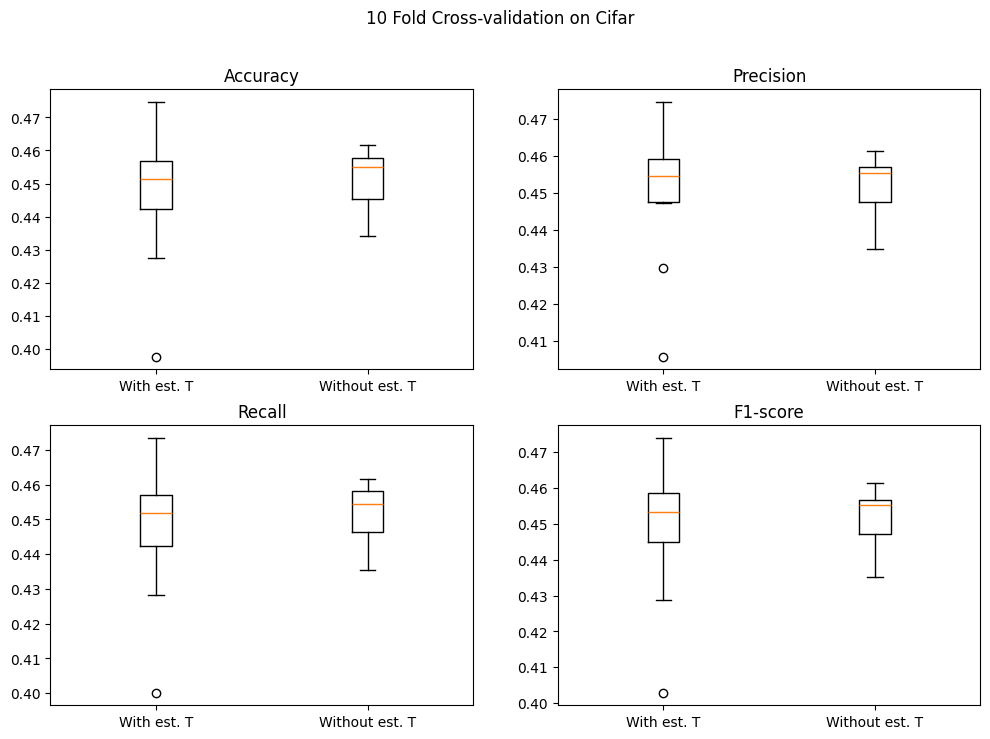

In [33]:
# Create subplots
fig, axs = plt.subplots(2, 2,figsize=(12, 8))

# Put all subplots together
axs[0, 0].boxplot(cifar_results.iloc[:,[0,4]])
axs[0, 0].set_xticks([1,2],['With est. T','Without est. T'])
axs[0, 0].set_title('Accuracy')
axs[0, 1].boxplot(cifar_results.iloc[:,[1,5]])
axs[0, 1].set_xticks([1,2],['With est. T','Without est. T'])
axs[0, 1].set_title('Precision')
axs[1, 0].boxplot(cifar_results.iloc[:,[2,6]])
axs[1, 0].set_xticks([1,2],['With est. T','Without est. T'])
axs[1, 0].set_title('Recall')
axs[1, 1].boxplot(cifar_results.iloc[:,[3,7]])
axs[1, 1].set_xticks([1,2],['With est. T','Without est. T'])
axs[1, 1].set_title('F1-score')

fig.suptitle('10 Fold Cross-validation on Cifar', fontsize=12)
plt.savefig('10-fold prediction Cifar.png')
plt.show()


In [34]:
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 3952.6586620807648 seconds
